# 팀 스마일C 코드 제출
* 팀원: 정우섭, 김유민, 김유진, 장동언, 황정묵
* PRIVATE SCORE: 0.65887 
* PRIVATE RANKING: 36

# 개발 환경
* OS : Windows11
* python: 3.10.10
* 라이브러리 버전 : requirements.txt 참조

# 0.Data Load
1. install packages
2. import libraries and csv data files

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install optuna 
!pip install xgboost
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 20.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 683.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns 

# model evaluation, preprocessing 
import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, log_loss

# sequential model modeling 
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras import backend as K 
from keras import regularizers
from keras.layers import Dense,Dropout, Activation, BatchNormalization, Conv2D, Flatten  
from keras import optimizers, metrics, callbacks
from keras.backend import clear_session

# optuna Hyper-params tuning
!pip install optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

# ML classification models 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

# # Google Drive mount
# from google.colab import drive 
# drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# seed fixing for reproduction 
import torch 
import random as rn 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정
seed_num=37

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(37)
seed_num=37
seed=37

np.random.seed(seed_num)
rn.seed(seed_num) 
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(config=session_conf)
K.set_session(sess)

class config:   
    seed = 37  
    device = "cuda:0"            

def seed_everything(seed: int = 37):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything(config.seed)
tf.random.set_seed(37) # tensorflow global seed 
print(config.seed)     

37


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID'])   

# 1.Data & Features

## 1.1 EDA
1. feature correlation heatmaps
2. feature importance
3. feature distribution plots

In [ ]:
# # random 20 features list (모두 NaN인 컬럼 제외하고, 랜덤 20개 feature의 상관관계 히트맵)
# Xs = train_df.iloc[:,4:].columns
# null_count = train_df.isnull().sum().to_dict()
# cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
# cols_name = list(cols[0])  # not_all_NAN features name in list 

# import random
# a = ['Y_Quality']
# for i in range(20):
#     num = random.randint(1,3326)
#     a.append(cols_name[i])

# # heatmap: `random X features` and `Y_Quality` correlation
# corr = train_df[a].corr()  # correlation matrix
# fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

In [ ]:
# # feature 중요도
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.ensemble import RandomForestRegressor

# qual_col = ['LINE', 'PRODUCT_CODE']
# for i in qual_col:
#     le = LabelEncoder()
#     le = le.fit(train_x[i])
#     train_x[i] = le.transform(train_x[i])
#     for label in np.unique(test_x[i]):
#         if label not in le.classes_:
#             le.classes_ = np.append(le.classes_, label)
#     test_x[i] = le.transform(test_x[i])

# train_x = train_x.fillna(0)
# test_x = test_x.fillna(0)
# X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

# %matplotlib inline
# RF = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
# RF.fit(X_train, y_train)
# ftr_importances_values = RF.feature_importances_
# ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
# ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
# plt.figure(figsize=(10, 10))
# sns.barplot(x=ftr_top, y=ftr_top.index)
# plt.show()      

In [ ]:
# feature distribution 
train_x.describe()    

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
count,838.000000,838.000000,838.0,838.000000,838.000000,838.0,838.000000,838.000000,838.000000,838.0,...,153.000000,1.530000e+02,153.000000,153.000000,153.000000,153.000000,153.000000,1.530000e+02,153.000000,153.000000
mean,2.755370,94.953461,0.0,45.005967,10.335322,0.0,48.587112,10.027446,41.875895,2.0,...,0.000007,3.666993e-06,0.190375,0.000021,0.000971,0.000032,0.000003,2.161843e-06,0.188588,0.000017
std,9.155686,4.212002,0.0,0.077059,0.472385,0.0,3.951187,0.163477,10.499536,0.0,...,0.000001,7.589918e-07,0.000870,0.000011,0.000280,0.000010,0.000001,6.646358e-07,0.001444,0.000012
min,1.000000,87.000000,0.0,45.000000,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,0.000004,2.630000e-06,0.188860,0.000007,0.000644,0.000019,0.000002,4.130000e-07,0.185000,0.000003
25%,2.000000,93.000000,0.0,45.000000,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,0.000007,3.230000e-06,0.189687,0.000010,0.000672,0.000023,0.000003,1.570000e-06,0.187000,0.000005
50%,2.000000,95.000000,0.0,45.000000,10.000000,0.0,50.000000,10.000000,52.000000,2.0,...,0.000007,3.420000e-06,0.190287,0.000013,0.001180,0.000028,0.000003,2.360000e-06,0.189000,0.000007
75%,2.000000,98.000000,0.0,45.000000,11.000000,0.0,51.000000,10.000000,52.000000,2.0,...,0.000008,3.890000e-06,0.191110,0.000032,0.001230,0.000041,0.000004,2.710000e-06,0.189000,0.000030
max,154.000000,102.000000,0.0,46.000000,11.000000,0.0,67.000000,11.000000,52.000000,2.0,...,0.000010,7.070000e-06,0.193656,0.000035,0.001310,0.000048,0.000007,3.410000e-06,0.193000,0.000033


<Axes: xlabel='X_2794', ylabel='Count'>

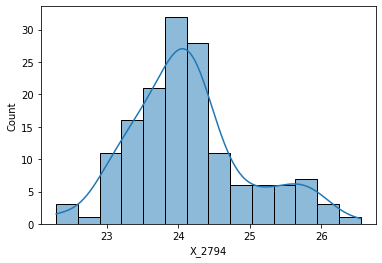

In [ ]:
# feature histogram with KDE (밀도그래프) 
# 임의의 feature에 대한 histplot + 밀도 곡선 출력
num = random.randint(1,3326)
sns.histplot(train_x[f'X_{num}'], kde=True)

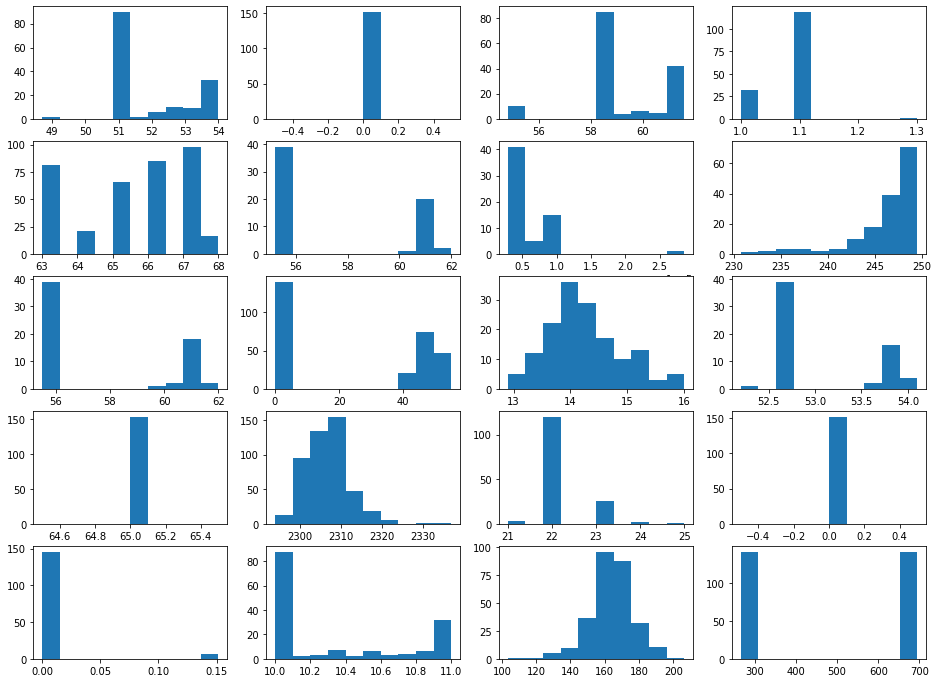

In [ ]:
# visualize random 20 features distribution 
# imbalanced feature distribution (NO Gaussian distribution shape) --> MinMaxscaler
fig, axes = plt.subplots(5,4,figsize=(16,12))
ax= axes.flatten()

for i in range(20): 
    num = random.randint(1,3326)
    ax[i].hist(train_x[f'X_{num}']);    

## 1.2 Preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler

In [ ]:
# train_df = pd.read_csv('./train.csv')
# test_df = pd.read_csv('./test.csv')
# submit = pd.read_csv('./sample_submission.csv')

# train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
# train_y = train_df['Y_Class']
# test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

In [ ]:
# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # one-hot encoding (X): get_dummies(test_df) is not allowed (data leakage)   
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 


In [ ]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df):
    for x in train_x.columns[6:]:
        if train_x[x].nunique()==0 or len(train_x[x].unique())==1: # nan 이거나 모두 같은 값인 경우
            train_x.drop(columns=[x], inplace=True) 
            test_x.drop(columns=[x], inplace=True)       
    return train_df

train = remove_col(train_df) 

In [ ]:
# 2) Missing Values 
# train_x = train_x.fillna(0)
# test_x = test_x.fillna(0)

In [ ]:
# 3) MinMaxscaling: only `X_???` values (continuous)
# Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
# scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
# train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
# test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

# KNN Imputer 
from sklearn.impute import KNNImputer

# Impute missing values using KNN imputer on train data
imputer = KNNImputer(n_neighbors=5)   # n_neighbors: params
imputer.fit(train_x)
                                 
train_x = imputer.transform(train_x)    
test_x = imputer.transform(test_x) 
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)
train_x.head()

# # Define columns with missing values
# missing_cols = ['X_{}'.format(i) for i in range(1, 3327)]

# # Impute missing values using KNN imputer on train data
# imputer = KNNImputer(n_neighbors=5)
# imputer.fit(train_x)
            
# # imputer = KNNImputer(n_neighbors=1)
# # imputer.fit(train)   
                                       
# train_x = imputer.transform(train_x) 
# test_x = imputer.transform(test_x)    

# train_x = pd.DataFrame(train_x)
# test_x = pd.DataFrame(test_x)
# train_x.head()


X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

In [ ]:
print(train_x.shape)

(1132, 3254)


# 2.Modeling

## 2.1 ML models
- 여러 Machine Learning Classifier 모델들의 test set Accuracy score 도출 
    - Ensemble에서 각 모델의 weight(가중치) 정하기 위한 근거로 사용하기 위함
1. RandomForestClassifier
2. GradientboostingClassiifer
3. XGBClassifier
4. LGBMClassifier
5. CatboostClassifier
6. RidgeClassifier
7. BaggingClassifier

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    RandomForestClassifier(random_state=seed_num), 
    GradientBoostingClassifier(random_state=seed_num),      
    XGBClassifier(random_state=seed_num),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    RidgeClassifierCV(),  # RidgeClassifier: no seed setting argument  
    BaggingClassifier(random_state=seed_num)]

In [ ]:
# # find weights for each model 
# model_list = ['RF', 'GBC', 'XGB', 'LGBM', 'Catboost', 'Ridge', 'Bagging']
# i=0
# model_acc = {}

# for model in models:  
#     if i == 4: 
#         preds = model.fit(X_train, y_train).predict(X_test)
#         preds = preds.reshape(1,340)
#         preds = list(preds[0])
#     else: 
#         preds = model.fit(X_train, y_train).predict(X_test)

#     globals()[f'preds_{model_list[i]}'] = preds   # set variable name for each model prediction results  
  
#     score = sklearn.metrics.accuracy_score(y_test, preds)
#     model_acc[model_list[i]] = score
#     i += 1   

# print(model_acc)   

In [ ]:
# # ML models accuracy comparison plot 
# model_name = list(model_acc.keys())
# model_acc = list(model_acc.values())
# acc_dic = {'model': model_name, 'acc': model_acc}
# acc_df = pd.DataFrame(acc_dic)
# acc_df = acc_df.set_index('model')

# acc_df.plot(kind='barh', figsize=(14,8),
#             title='Model Comparison - accuracy score');

## 2.2 Sequential MLP 
* Deep Learning Modeling: Sequential MLP model

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F 

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        """
        parameters: 
            input_dim (int): 입력 벡터 크기
            hidden_dim1 (int): 첫 번째 Linear 층의 출력 크기
            hidden_dim2 (int): 두 번째 Linear 층의 출력 크기 
            output_dim (int): 세 번째 Linear 층의 출력 크기 
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
       # self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """
        MLP의 정방향 계산 

        parameters:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)
            apply_softmax (multiclasses): softmax activation function 
        return: 
            result Tensor
            tesnor.shape: (batch, output_dim)
        """
        intermediate1 = F.relu(self.fc1(x_in))   # activation function
        intermediate2 = F.relu(self.fc2(intermediate1))   # activation function
       # intermediate3 = F.relu(self.fc3(intermediate2))   # activation function
        output = self.fc4(intermediate2)    


        if apply_softmax: 
            output = F.softmax(output, dim=1)   # output layer: softmax activation function
        return output 

In [ ]:
def describe(x): 
    print(f'Type: {x.type()}')
    print(f'shape: {x.shape}')
    # print(f'value: {x}') 

batch_size = 256 
input_dim = train_x.shape[-1]
hidden_dim1 = 1024
hidden_dim2 = 512
output_dim = 3 

# model design 
mlp = MultilayerPerceptron(input_dim, hidden_dim1, hidden_dim2, output_dim)
print(mlp)
x_input = torch.rand(batch_size, input_dim)
y_output = mlp(x_input, apply_softmax=True)  # result: probabilities format 
a = y_output
describe(y_output)

MultilayerPerceptron(
  (fc1): Linear(in_features=3254, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)
Type: torch.FloatTensor
shape: torch.Size([256, 3])


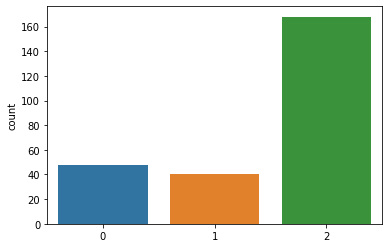

In [ ]:
prediction=[]

for i in a: 
    i = list(i)
    prediction.append(i.index(max(i)))

sns.countplot(x=prediction);    

# 3.Params Optimization
1. Optuna
2. GridSearch 

## 3.1 Light Gradient Boosting
1. Optuna
    - hyperparameters auto optimization

In [ ]:
# def objective(trial, X, y, cv, scoring):
#     params = {
#         'lambda_l1' : trial.suggest_loguniform('lambda_l1', 1e-8, 1e-1),
#         'lambda_l2' : trial.suggest_loguniform('lambda_l2', 1e-8, 1e-1),
#         'path_smooth' : trial.suggest_loguniform('path_smooth', 1e-8, 1e-3),
#         'num_leaves' : trial.suggest_int('num_leaves', 30, 200),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
#         'max_bin' : trial.suggest_int('max_bin', 100, 255),
#         'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.5, 0.9),
#         'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.5, 0.9),
#     }
#   # Perform cross validation
#   # gb_class = GradientBoostingClassifier(**params)
#     lgbm_class = LGBMClassifier(**params)

#   # Compute scores
#     scores = cross_validate(lgbm_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
#     accuracy = scores["test_score"].mean()
#     return accuracy

- Optimization for params

    - K-Fold, trials = 10

In [ ]:
# sampler = optuna.samplers.TPESampler(seed=10, gpu_properties={'device_id': 0})
# study = optuna.create_study(direction = "maximize")
# study.set_user_attr("verbose", True)

# kf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

# func = lambda trial: objective(trial, X_train, y_train, cv = kf, scoring = "accuracy")

# # # %%time
# # # Start optimizing with 100 trials
# study.optimize(func, n_trials = 10,n_jobs=-1)

# print(f"The highest accuracy reached by this study: {(study.best_value) * 100}%.")
# print("Best params:")
# for key, value in study.best_params.items():
#     print(f"\t{key}: {value}")    

In [ ]:
import imblearn

params= {'lambda_l1': 0.00048021471491299205,'lambda_l2': 0.021386150387940235,
         'path_smooth': 4.976692465226837e-07,'num_leaves': 83,
         'min_data_in_leaf': 16,'max_bin': 219,
         'feature_fraction': 0.6536282159518209,'bagging_fraction': 0.7302696718518357,}
# GBC =  GradientBoostingClassifier(random_state=37, **params,                              
#                                   ).fit(X_train, y_train)
# preds = GBC.predict(X_test)
LGBM =  LGBMClassifier(random_state=37, **params,).fit(X_train, y_train)
lgbm_preds = LGBM.predict(X_test)
# LGBMClassifier(objective='multiclass', random_state=seed_num)
print(classification_report(y_test, lgbm_preds))
print("\n Optuna : ", accuracy_score(y_test, lgbm_preds))

[LightGBM] [Warning] lambda_l1 is set=0.00048021471491299205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048021471491299205
[LightGBM] [Warning] bagging_fraction is set=0.7302696718518357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302696718518357
[LightGBM] [Warning] feature_fraction is set=0.6536282159518209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536282159518209
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.021386150387940235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021386150387940235
              precision    recall  f1-score   support

           0       0.61      0.38      0.47        53
           1       0.77      0.93      0.84       227
           2       0.71      0.42      0.53        60

    accuracy                           0.75       340
   macro avg       0.70   

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour
#plot_param_importances(study)

In [ ]:
RF=RandomForestClassifier(random_state=seed_num).fit(X_train,y_train)
rf_pred=RF.predict(X_test)
print("acc: ",accuracy_score(y_test, lgbm_preds))



acc:  0.75


In [ ]:
from sklearn.model_selection import cross_val_score
# Change following line to range(NFOLDS) to run & find best params.
# for fold_id in range(5, 5):
#     print('========== Processing fold', fold_id, '==========')

import optuna

# 1. 최소화/최대화할 목적함수 정의
def objective(trial):

# 2. trial object로 하이퍼파라미터 값 추천
# 다양한 분류모델을 설정해서 비교할 수 있다.
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest'])
    # #분류 모델이 SVC일 때
    # if classifier_name == 'SVC':
    #     svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
    #     classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    
    #분류모델이 랜덤포레스트일 때
    # else:
    # rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
    # tfidf__analyzer = trial.suggest_categorical('tfidf__analyzer', ['word', 'char', 'char_wb']) 
    # tfidf__lowercase = trial.suggest_categorical('tfidf__lowercase', [False, True]) 
    tfidf__max_features = trial.suggest_int('tfidf__max_features', 500, 10_000) 
    rf__n_estimators = trial.suggest_int('rf__num_estimators', 300, 500) 
    rf__max_depth = trial.suggest_int('rf__max_depth', 5, 15) 
    rf__min_samples_split = trial.suggest_int('rf__min_samples_split', 10, 30) 
    

    classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf__max_depth, 
                                                             n_estimators=rf__n_estimators,
                                                             max_features=tfidf__max_features,
                                                             min_samples_split = rf__min_samples_split)
    
    accuracy = cross_val_score(classifier_obj, train_x, train_y, cv = 5).mean()
    return accuracy
    
# 3. study 오브젝트 생성하고 목적함수 최적화하는 단계
# 여기서는 목적함수를 정확도로 설정했기 때문에 최대화를 목표로 하고 있지만, 손실함수의 경우 direction='minimize'로 설정
study = optuna.create_study(direction='maximize')
# 반복 시행 횟수(trial)는 200번으로
study.optimize(objective, n_trials=200)

# Trial 42 finished with value: 0.7667966161163308 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 17.53243068297166}. 

[I 2023-03-26 00:29:48,106] A new study created in memory with name: no-name-b47297d4-2b14-4a0d-8df9-f2ba588601d5
[I 2023-03-26 00:37:11,811] Trial 0 finished with value: 0.7517679622626797 and parameters: {'classifier': 'RandomForest', 'tfidf__max_features': 5234, 'rf__num_estimators': 451, 'rf__max_depth': 7, 'rf__min_samples_split': 28}. Best is trial 0 with value: 0.7517679622626797.
[I 2023-03-26 00:42:04,092] Trial 1 finished with value: 0.7526412225644225 and parameters: {'classifier': 'RandomForest', 'tfidf__max_features': 9419, 'rf__num_estimators': 369, 'rf__max_depth': 5, 'rf__min_samples_split': 14}. Best is trial 1 with value: 0.7526412225644225.
[I 2023-03-26 00:52:24,460] Trial 2 finished with value: 0.7650072121944563 and parameters: {'classifier': 'RandomForest', 'tfidf__max_features': 8804, 'rf__num_estimators': 394, 'rf__max_depth': 14, 'rf__min_samples_split': 21}. Best is trial 2 with value: 0.7650072121944563.
[I 2023-03-26 00:57:30,506] Trial 3 finished with valu

KeyboardInterrupt: ignored

In [ ]:
import joblib 
from sklearn.pipeline import Pipeline

model = Pipeline([('rf', RandomForestClassifier)])
def objective(trial):    
    
    joblib.dump(study, 'study.pkl')
    
    tfidf__analyzer = trial.suggest_categorical('tfidf__analyzer', ['word', 'char', 'char_wb']) 
    tfidf__lowercase = trial.suggest_categorical('tfidf__lowercase', [False, True]) 
    tfidf__max_features = trial.suggest_int('tfidf__max_features', 500, 10_000) 
    rf__n_estimators = trial.suggest_int('rf__num_estimators', 300, 500) 
    rf__max_depth = trial.suggest_int('rf__max_depth', 5, 15) 
    rf__min_samples_split = trial.suggest_int('rf__min_samples_split', 10, 30) 
    
   
    

    params = {
        'tfidf__analyzer': tfidf__analyzer,
        'tfidf__lowercase': tfidf__lowercase,
        'tfidf__max_features': tfidf__max_features,
        'rf__n_estimators': rf__n_estimators,
        'rf__max_depth': rf__max_depth,
        'rf__min_samples_split': rf__min_samples_split,
       
    }
    
    model.set_params(**params)   

    return  -np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,scoring='neg_log_loss'))

# by default, the direction is to minimizae, but can set it to maximize too
#study = optuna.create_study(direction='minimize')
study = optuna.create_study()


#study.optimize(objective, timeout=3600)
study.optimize(objective, n_trials=20)


# to record the value for the last time
joblib.dump(study, 'study.pkl')

[I 2023-03-26 00:23:36,797] A new study created in memory with name: no-name-0ce01b3b-a59b-4f04-89fb-fae10598cc9e
[W 2023-03-26 00:23:36,804] Trial 0 failed with parameters: {'tfidf__analyzer': 'char_wb', 'tfidf__lowercase': False, 'tfidf__max_features': 5827, 'rf__num_estimators': 402, 'rf__max_depth': 5, 'rf__min_samples_split': 15} because of the following error: TypeError("get_params() missing 1 required positional argument: 'self'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-20-c7773dabaf25>", line 30, in objective
    model.set_params(**params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 211, in set_params
    self._set_params("steps", **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/metaestimators.py", line 70, in _set_params
    super().set_params(**params)
  File "/usr/local/lib/

TypeError: ignored

In [ ]:
RF = RandomForestClassifier(max_depth= int(17.53243068297166), 
                            n_estimators=10,
                            random_state=seed_num)

### 3.1.1 GridSearch

- hyperparameter optimization

In [ ]:
# CBC = CatBoostClassifier(task_type='GPU', border_count=None)
# params_grid = {'iterations': [600, 700, 800, 900, 1000],
#                'depth': [4, 5, 6],
#                'loss_function': ['MultiClass'],
#                'l2_leaf_reg': np.logspace(-20, -19, 3),
#                'leaf_estimation_iterations': [10],
#                'eval_metric': ['Accuracy'],
#                'logging_level':['Silent'],
#                'random_seed': [42]}


In [ ]:
# from sklearn.model_selection import GridSearchCV

# estimator = GradientBoostingClassifier(random_state = 37)

# param_grid = {
#             'n_estimators' : [n_estimators for n_estimators in range(100, 5000, 100)],
#             'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
#             'max_depth' : [depth for depth in range(3, 9)],
#             'subsample' : [subsample * 0.1 for subsample in range(5, 9, 1)],
#             'max_features' : ['auto', 'sqrt', 'log2']
#             }

# # scoring = 'r2' -> 결정계수로 scoring
# grid_GBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
# grid_GBC.fit(train_x, train_y)

# print('best estimator model: \n{}'.format(grid_GBC.best_estimator_))
# print('\nbest parameter: \n{}'.format(grid_GBC.best_params_))
# print("\nbest score: \n{}".format(grid_GBC.best_score_.round(3)))

In [ ]:
# # GridSearch best parameter 
# import imblearn

# params= {'n_estimators': 1200, 'learning_rate': 0.009147154102399788, \
#         'max_depth': 9, 'subsample': 0.8, 'max_features': 'auto'}
# GBC =  GradientBoostingClassifier(random_state=37, **params,                              
#                                   ).fit(X_train, y_train)
# preds = GBC.predict(X_test)

# print(classification_report(y_test, preds))
# print("\n Grid : ", accuracy_score(y_test, preds))

## 3.2 CatBoost
1. optuna 
    - hyperparameters auto optimization

In [ ]:
# def objective(trial):
#     params = {
#         "iterations": 1000,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 10),
#         "random_seed": 42,
#         "eval_metric": "Accuracy",
#         "od_type": "Iter",
#         "od_wait": 100,
#         "verbose": 1
#     }    


#     # iterations=trial.suggest_int("iterations", 100, 1000),
#     #     learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#     #     depth=trial.suggest_int("depth", 4, 10),
#     #     l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#     #     bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#     #     random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#     #     bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
#     #     od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#     #     od_wait=trial.suggest_int("od_wait", 10, 50),
#     #     verbose=False
#     model=CatBoostClassifier(**params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return f1_score(y_test, y_pred, average='macro')
     
# # # hyper-parameter tuning with OPTUNA  
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=37)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.set_user_attr("verbose", 1)
# study.optimize(objective, n_trials=0,n_jobs=-1)  

In [ ]:
# print("Number of trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ",trial.params)

# CBC_model = CatBoostClassifier(**trial.params, verbose=False, random_state = 37)
# CBC_model.fit(X_train, y_train,verbose=1)
# y_pred = model.predict(X_test)


In [ ]:
params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, \
        'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', \
        'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, \
        'od_type': 'IncToDec', 'od_wait': 42}
CBC = CatBoostClassifier(**params, verbose=0, random_state=37, task_type='GPU')
CBC.fit(X_train, y_train)
preds_CBC = CBC.predict(X_test)

print(classification_report(y_test, preds_CBC))
print("\n Optuna : ", accuracy_score(y_test, preds_CBC))

              precision    recall  f1-score   support

           0       0.64      0.26      0.37        53
           1       0.75      0.94      0.83       227
           2       0.72      0.38      0.50        60

    accuracy                           0.74       340
   macro avg       0.70      0.53      0.57       340
weighted avg       0.73      0.74      0.70       340


 Optuna :  0.7382352941176471


In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

In [ ]:
# plot_param_importances(study)

### 3.2.1 GridSearch

- hyperparameter optimization

In [ ]:
# from sklearn.model_selection import GridSearchCV

# estimator = CatBoostClassifier(random_state = 37)

# param_grid = {
#             'iterataions' : [iter for iter in range(100, 1000, 100)],
#             'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
#             'depth' : [depth for depth in range(4, 10)],
#             'l2_leaf_reg' : [leaf * 0.0000001 for leaf in range(1, 100, 10)],
#             'bootstrap_type' : ['Bayesian'],
#             'random_strength' : [strength * 0.1 for strength in range(1, 100, 10)],
#             'bagging_temperature' : [bag * 0.1 for bag in range(1, 10)],
#             'od_type' : ['IncToDec', 'Iter'],
#             'od_wait' : [wait for wait in range(10, 50, 4)]
#             }

# # scoring = 'r2' -> 결정계수로 scoring
# grid_CBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
# grid_CBC.fit(X_train, y_train)

# print('best estimator model: \n{}'.format(grid_CBC.best_estimator_))
# print('\nbest parameter: \n{}'.format(grid_CBC.best_params_))
# print("\nbest score: \n{}".format(grid_CBC.best_score_.round(3)))

In [ ]:
# param_grid={'iterations': [600, 700, 800, 900, 1000],
#             'depth': [4, 5, 6],
#             'loss_function': ['MultiClass'],
#             'l2_leaf_reg': np.logspace(-20, -19, 3),
#             'leaf_estimation_iterations': [10],
#             'eval_metric': ['Accuracy'],
#             'logging_level':['Silent'],
#             'random_seed': [42]
#            }
# catB=CatBoostClassifier()
# cat_grid=GridSearchCV(catB,param_grid=param_grid,scoring='accuracy',cv=5,n_jobs=-1)

# cat_grid.fit(X_train, y_train,verbose=1)

# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [ ]:
# params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, \
#         'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', \
#         'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, \
#         'od_type': 'IncToDec', 'od_wait': 42}
# CBC = CatBoostClassifier(**paarams, verbose=False, random_state=37)
# CBC.fit(X_train, y_train)
# preds_CBC = CBC.predict(X_test)

# print(classification_report(y_test, preds_CBC))
# print("\n Grid : ", accuracy_score(y_test, preds_CBC))

# 4.Ensemble

## 4.1 VotingClassifier
1. 3-ensemble Modle
2. Cross-Validation 구축 후 성능 검증

In [ ]:
models=[CBC,RF,LGBM]   
fit= [x.fit(train_x, train_y) for x in models]

[LightGBM] [Warning] lambda_l1 is set=0.00048021471491299205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048021471491299205
[LightGBM] [Warning] bagging_fraction is set=0.7302696718518357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302696718518357
[LightGBM] [Warning] feature_fraction is set=0.6536282159518209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536282159518209
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.021386150387940235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021386150387940235


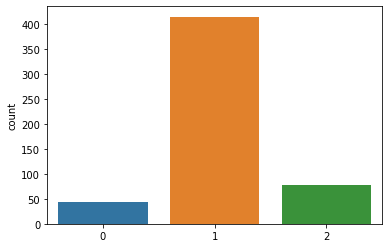

In [ ]:
def prediction(models, test, mode=None, weights=None):
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )  
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

preds = prediction(models, test_x, 'hard', [2,5,4] )

sns.countplot(x=preds);   


## 4.2 Validation Score
1. train.csv에서 split된 test set accuracy 100% 검증

In [ ]:
voting_model = sklearn.ensemble.VotingClassifier(estimators=[
                ('CatBoostClassifier', CBC),
                ('RandomForest', RF),
                ('LGBM', LGBM)], 
                voting='hard', weights=[2,1,2])

In [ ]:
val_preds = prediction(models, X_test, 'hard', [2,1,2])
val_score= sklearn.metrics.accuracy_score(y_test, val_preds)
val_score  

1.0

# 5.Submit

In [ ]:
submit = pd.read_csv('sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('KNNimputerDropNA-CRL254RFoptuna.csv', index=False)
pd.DataFrame(preds).value_counts()

1    414
2     77
0     44
dtype: int64

# 6.References
PPT에 기재하였습니다


# THE END